In [46]:
# import the libraries and connect to the database
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# restart a new connection
conn = mysql.connector.connect(user='root', password='sql',
                              host='localhost')
cur = conn.cursor(buffered=True)
cur.execute("USE `sales`")

In [2]:
# correlation between transactions and sales
sql = '''
    with cte as (
        select date, store_nbr, sum(sales) as sales
        from train
        group by date, store_nbr
    )
    select transactions, sales
    from cte left join transactions t on t.date = cte.date and cte.store_nbr = t.store_nbr;
'''
cur.execute(sql)
query = cur.fetchall()
sales_trans = pd.DataFrame(query, columns=['transactions', 'sales'])
sales_trans.head()

,transactions,sales
0,770.0,2511.619003
1,2111.0,7417.148018
2,1293.0,5430.088013
3,3547.0,18329.638004
4,1362.0,5854.516998


In [3]:
sales_trans.transactions = sales_trans.transactions.astype('float')
# correlation between transactions and sales
sales_trans['transactions'].corr(sales_trans['sales'], method='pearson')

0.8373836801653558

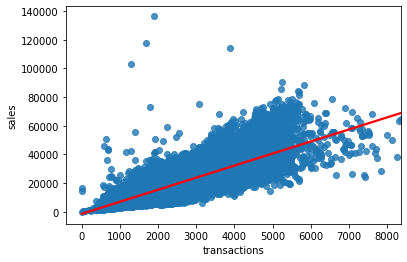

In [4]:
sns.regplot(x='transactions', y='sales', data=sales_trans, line_kws={"color":"r"})
plt.show()

In [5]:
# examine the daily transactions across stores
sql = "SELECT * FROM transactions"
cur.execute(sql)
query = cur.fetchall()
transactions = pd.DataFrame(query, columns=['date', 'store_nbr', "transactions"])
transactions.date = pd.to_datetime(transactions.date)
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [6]:
# examine the average monthly transactions
sql = "SELECT DATE_FORMAT(date,'%Y-%m') as date, round(avg(transactions),2) as transactions FROM transactions GROUP BY DATE_FORMAT(date,'%Y-%m')"
cur.execute(sql)
query = cur.fetchall()
monthly_transactions = pd.DataFrame(query, columns=['date', "transactions"])
monthly_transactions.date = pd.to_datetime(monthly_transactions.date)
monthly_transactions.head()

,date,transactions
0,2013-01-01,1657.90
1,2013-02-01,1684.48
2,2013-03-01,1724.18
3,2013-04-01,1699.21
4,2013-05-01,1702.87


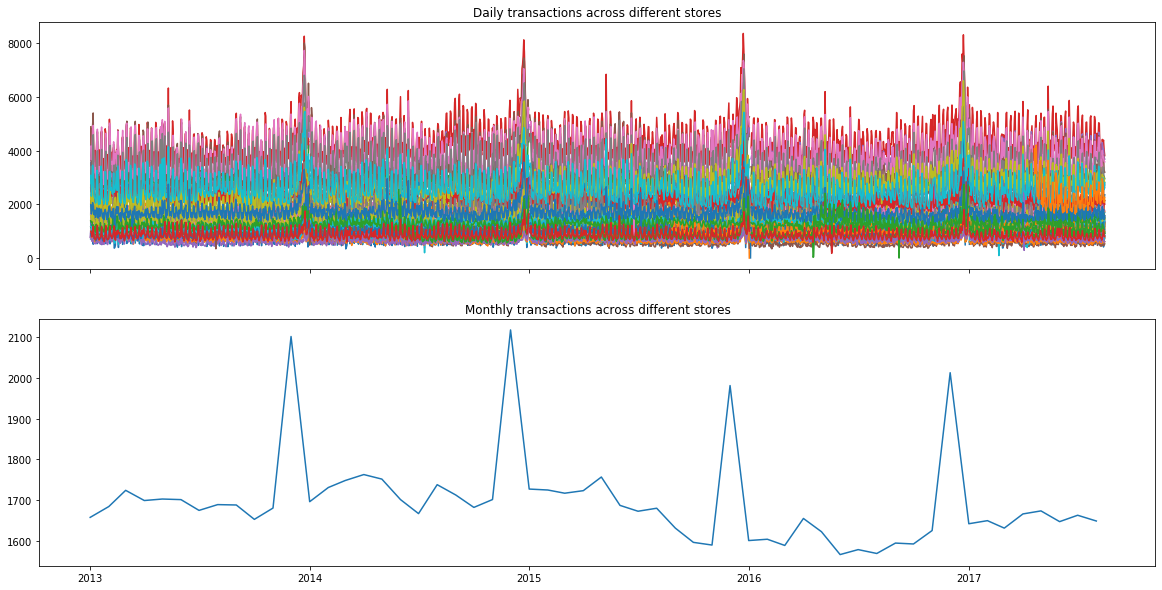

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
transactions_pivot = pd.pivot_table(transactions, index='date', values='transactions',columns='store_nbr', fill_value=np.nan)
ax[0].plot(transactions_pivot)
ax[0].set_title("Daily transactions across different stores")

ax[1].plot(monthly_transactions.date, monthly_transactions.transactions)
ax[1].set_title("Monthly transactions across different stores")

plt.show()

Pattern 1: More transactions towards the end of the year.

In [8]:
# examine the average number of transactions by days of weeks and days of month
sql = '''
select dayname(date) as dow, round(avg(transactions),2) as transactions, '2013' as year from transactions 
where year(date) = 2013
group by dayname(date)
union
select dayname(date) as dow, round(avg(transactions),2) as transactions, '2014' as year from transactions 
where year(date) = 2014
group by dayname(date)
union
select dayname(date) as dow, round(avg(transactions),2) as transactions, '2015' as year from transactions 
where year(date) = 2015
group by dayname(date)
union
select dayname(date) as dow, round(avg(transactions),2) as transactions, '2016' as year from transactions 
where year(date) = 2016
group by dayname(date)
union
select dayname(date) as dow, round(avg(transactions),2) as transactions, '2017' as year  from transactions 
where year(date) = 2017
group by dayname(date);
'''
cur.execute(sql)
query = cur.fetchall()
dow_transactions = pd.DataFrame(query, columns=['dow', "transactions", "year"])
dow_order = pd.CategoricalDtype(categories =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
dow_transactions.dow = dow_transactions.dow.astype(dow_order)
dow_transactions.sort_values(['year','dow'], inplace=True)
dow_transactions.head()

,dow,transactions,year
6,Monday,1681.43,2013
0,Tuesday,1630.49,2013
1,Wednesday,1627.74,2013
2,Thursday,1565.65,2013
3,Friday,1650.34,2013


In [9]:
sql = '''
select dayofmonth(date) as dom, round(avg(transactions),2) as transactions, '2013' as year from transactions 
where year(date) = 2013
group by dayofmonth(date)
union
select dayofmonth(date) as dom, round(avg(transactions),2) as transactions, '2014' as year from transactions 
where year(date) = 2014
group by dayofmonth(date)
union
select dayofmonth(date) as dom, round(avg(transactions),2) as transactions, '2015' as year from transactions 
where year(date) = 2015
group by dayofmonth(date)
union
select dayofmonth(date) as dom, round(avg(transactions),2) as transactions, '2016' as year from transactions 
where year(date) = 2016
group by dayofmonth(date)
union
select dayofmonth(date) as dom, round(avg(transactions),2) as transactions, '2017' as year  from transactions 
where year(date) = 2017
group by dayofmonth(date);
'''
cur.execute(sql)
query = cur.fetchall()
dom_transactions = pd.DataFrame(query, columns=['dom', "transactions", "year"])
dom_transactions.head()

,dom,transactions,year
0,1,1840.48,2013
1,2,1856.78,2013
2,3,1772.82,2013
3,4,1715.88,2013
4,5,1750.12,2013


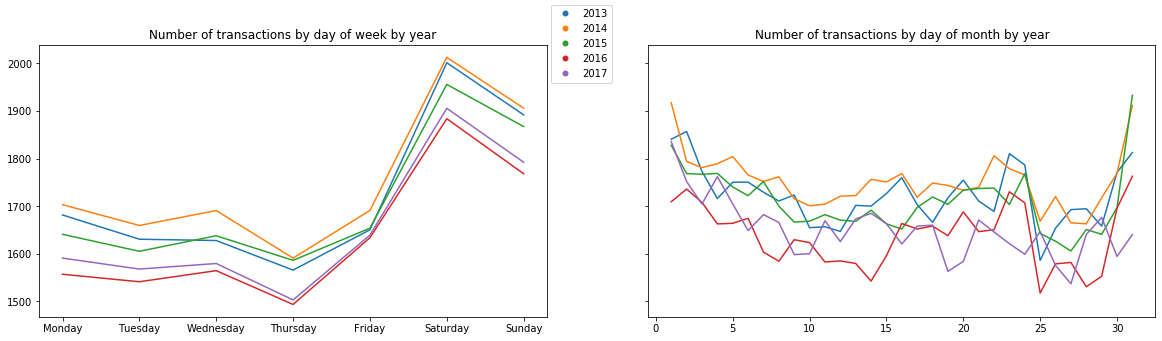

In [10]:
# define a helper function for legend of the visualization
def lp (i, j, ax, sc):
    return ax.plot([], color= sc[j].get_color(), mec="none", label="{}".format(i), ls="", marker="o")[0]

fig, ax = plt.subplots(1, 2, sharey=True,figsize=(20, 5))
dow_transactions_pivot = pd.pivot_table(dow_transactions, index='dow', values='transactions',columns='year', fill_value=np.nan)
sc = ax[0].plot(dow_transactions_pivot)
handles = [lp(i, j, ax[0], sc) for j, i in enumerate(dow_transactions_pivot.columns)]
ax[0].set_title("Number of transactions by day of week by year")

dom_transactions_pivot = pd.pivot_table(dom_transactions, index='dom', values='transactions',columns='year', fill_value=np.nan)
sc = ax[1].plot(dom_transactions_pivot)
ax[1].set_title("Number of transactions by day of month by year")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

Pattern 2: 

- Mid week: fewer transactions are made
- People make more purchases on weekends
- 30th - 1st are the days of month with most purchases, whereas transactions decrease for the rest of the period, except for the period from 16th to 23rd of each month. Note that 2017 only has the data until August, so it might explain why it diverts from the general trend a little bit. 

In [11]:
# examine the daily sales of products across all stores
sql = "SELECT date, family, sum(sales) as sales FROM train GROUP BY date, family"
cur.execute(sql)
query = cur.fetchall()
product_sales = pd.DataFrame(query, columns=['date', 'family', "sales"])
product_sales.date = pd.to_datetime(product_sales.date)
product_sales.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


In [12]:
# examine the monthly sales of products across all stores
sql = "SELECT DATE_FORMAT(date,'%Y-%m') as date, family, round(avg(sales),2) as sales FROM train GROUP BY DATE_FORMAT(date,'%Y-%m'), family"
cur.execute(sql)
query = cur.fetchall()
monthly_product_sales = pd.DataFrame(query, columns=['date', 'family', "sales"])
monthly_product_sales.date = pd.to_datetime(monthly_product_sales.date)
monthly_product_sales.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,3.92
1,2013-01-01,BABY CARE,0.00
2,2013-01-01,BEAUTY,2.40
3,2013-01-01,BEVERAGES,998.00
4,2013-01-01,BOOKS,0.00


In [13]:
# examine the total sales of products across all stores
sql = "SELECT family, sum(sales) as sales FROM train GROUP BY family"
cur.execute(sql)
query = cur.fetchall()
tot_product_sales = pd.DataFrame(query, columns=['family', "sales"])
tot_product_sales = tot_product_sales.sort_values(['sales'], ascending = False)
tot_product_sales.head()

,family,sales
12,GROCERY I,3.434627e+08
3,BEVERAGES,2.169545e+08
30,PRODUCE,1.227047e+08
7,CLEANING,9.752129e+07
8,DAIRY,6.448771e+07


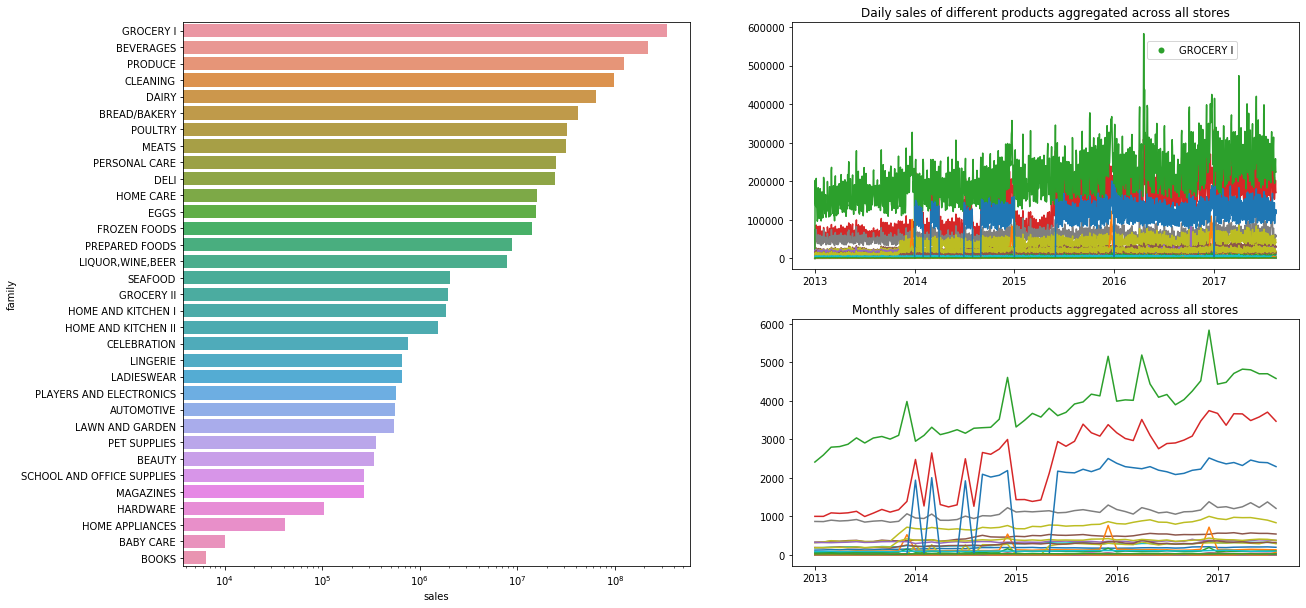

In [14]:
fig = plt.figure(figsize=(20, 10))

product_sales_pivot = pd.pivot_table(product_sales, index='date', values='sales',columns='family', fill_value=np.nan)
sub1 = fig.add_subplot(2, 2, 2)
sc = sub1.plot(product_sales_pivot)
sub1.set_title("Daily sales of different products aggregated across all stores")
max_val = product_sales_pivot.to_numpy().max()
handles = [lp(i, j, sub1, sc) for j, i in enumerate(product_sales_pivot.columns) if max(product_sales_pivot[i]) == max_val]
sub1.legend(handles=handles, loc=(0.7, 0.85))

monthly_product_sales_pivot = pd.pivot_table(monthly_product_sales, index='date', values='sales',columns='family', fill_value=np.nan)
sub2 = fig.add_subplot(2, 2, 4)
sub2.plot(monthly_product_sales_pivot)
sub2.set_title("Monthly sales of different products aggregated across all stores")

sub3 = fig.add_subplot(2, 2, (1,3))
g = sns.barplot(x="sales", y="family", data=tot_product_sales, ci=None, ax = sub3)
g.set_xscale('log')

plt.show()

In [15]:
# examine the relationship between store types and transactions
sql = '''
select year(date) as date, type, t.store_nbr, round(avg(transactions), 2) as transactions
from transactions t left join stores s using(store_nbr)
group by year(date), type, t.store_nbr;
'''
cur.execute(sql)
query = cur.fetchall()
store_types_transactions = pd.DataFrame(query, columns=['date', 'type', 'store_nbr', "transactions"])
store_types_transactions.head()

,date,type,store_nbr,transactions
0,2013,D,25,897.66
1,2013,D,1,1522.81
2,2013,D,2,1895.05
3,2013,D,3,3144.44
4,2013,D,4,1525.68


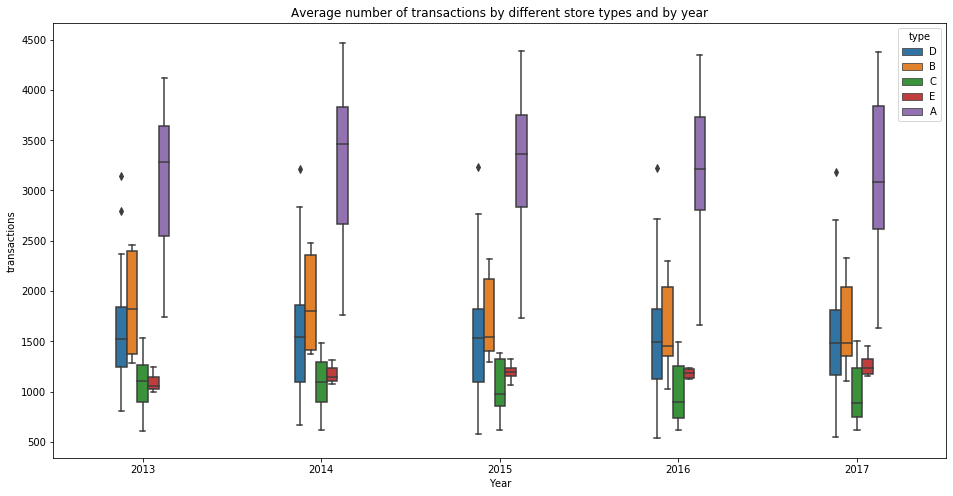

In [16]:
fig = plt.figure(figsize=(16, 8)) # Set the figure size
ax = fig.add_subplot(111)
store_types_transactions.transactions = pd.to_numeric(store_types_transactions.transactions)
sns.boxplot(data = store_types_transactions, x='date', y='transactions', hue='type', ax=ax, width=0.3)
ax.set_title('Average number of transactions by different store types and by year')
ax.set_xlabel('Year')
plt.show()

In [22]:
# oil price versus sales/num of transactions

sql ='''
select o.date, store_nbr, dcoilwtico, transactions
from oil o inner join transactions using(date);
'''
cur.execute(sql)
query = cur.fetchall()
oil_transaction = pd.DataFrame(query, columns=['date', 'store_nbr', 'dcoilwtico', 'transactions'])
oil_transaction.head()

,date,store_nbr,dcoilwtico,transactions
0,2013-01-01,25,NaN,770
1,2013-01-02,1,93.14,2111
2,2013-01-02,2,93.14,2358
3,2013-01-02,3,93.14,3487
4,2013-01-02,4,93.14,1922


In [25]:
# for sales level, aggregate by product too
sql ='''
with cte as (select date, store_nbr, family, sum(sales) as sales
from train group by train.date, store_nbr, family)

select o.date, dcoilwtico, store_nbr, family, sales
from oil o inner join cte c using(date);
'''
cur.execute(sql)
query = cur.fetchall()
oil_sales = pd.DataFrame(query, columns=['date', 'dcoilwtico', 'store_nbr', 'family', 'sales'])
oil_sales.head()

,date,dcoilwtico,store_nbr,family,sales
0,2013-01-01,NaN,1,AUTOMOTIVE,0.0
1,2013-01-01,NaN,1,BABY CARE,0.0
2,2013-01-01,NaN,1,BEAUTY,0.0
3,2013-01-01,NaN,1,BEVERAGES,0.0
4,2013-01-01,NaN,1,BOOKS,0.0


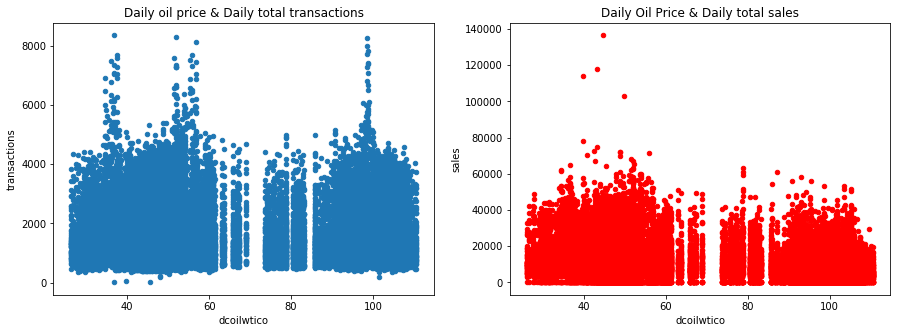

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
oil_transaction.plot.scatter(x = "dcoilwtico", y = "transactions", ax=axes[0])
oil_sales_gr = oil_sales.groupby(by=['date', 'store_nbr', 'dcoilwtico']).aggregate('sum').reset_index()
oil_sales_gr.plot.scatter(x = "dcoilwtico", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Daily total transactions')
axes[1].set_title('Daily Oil Price & Daily total sales');

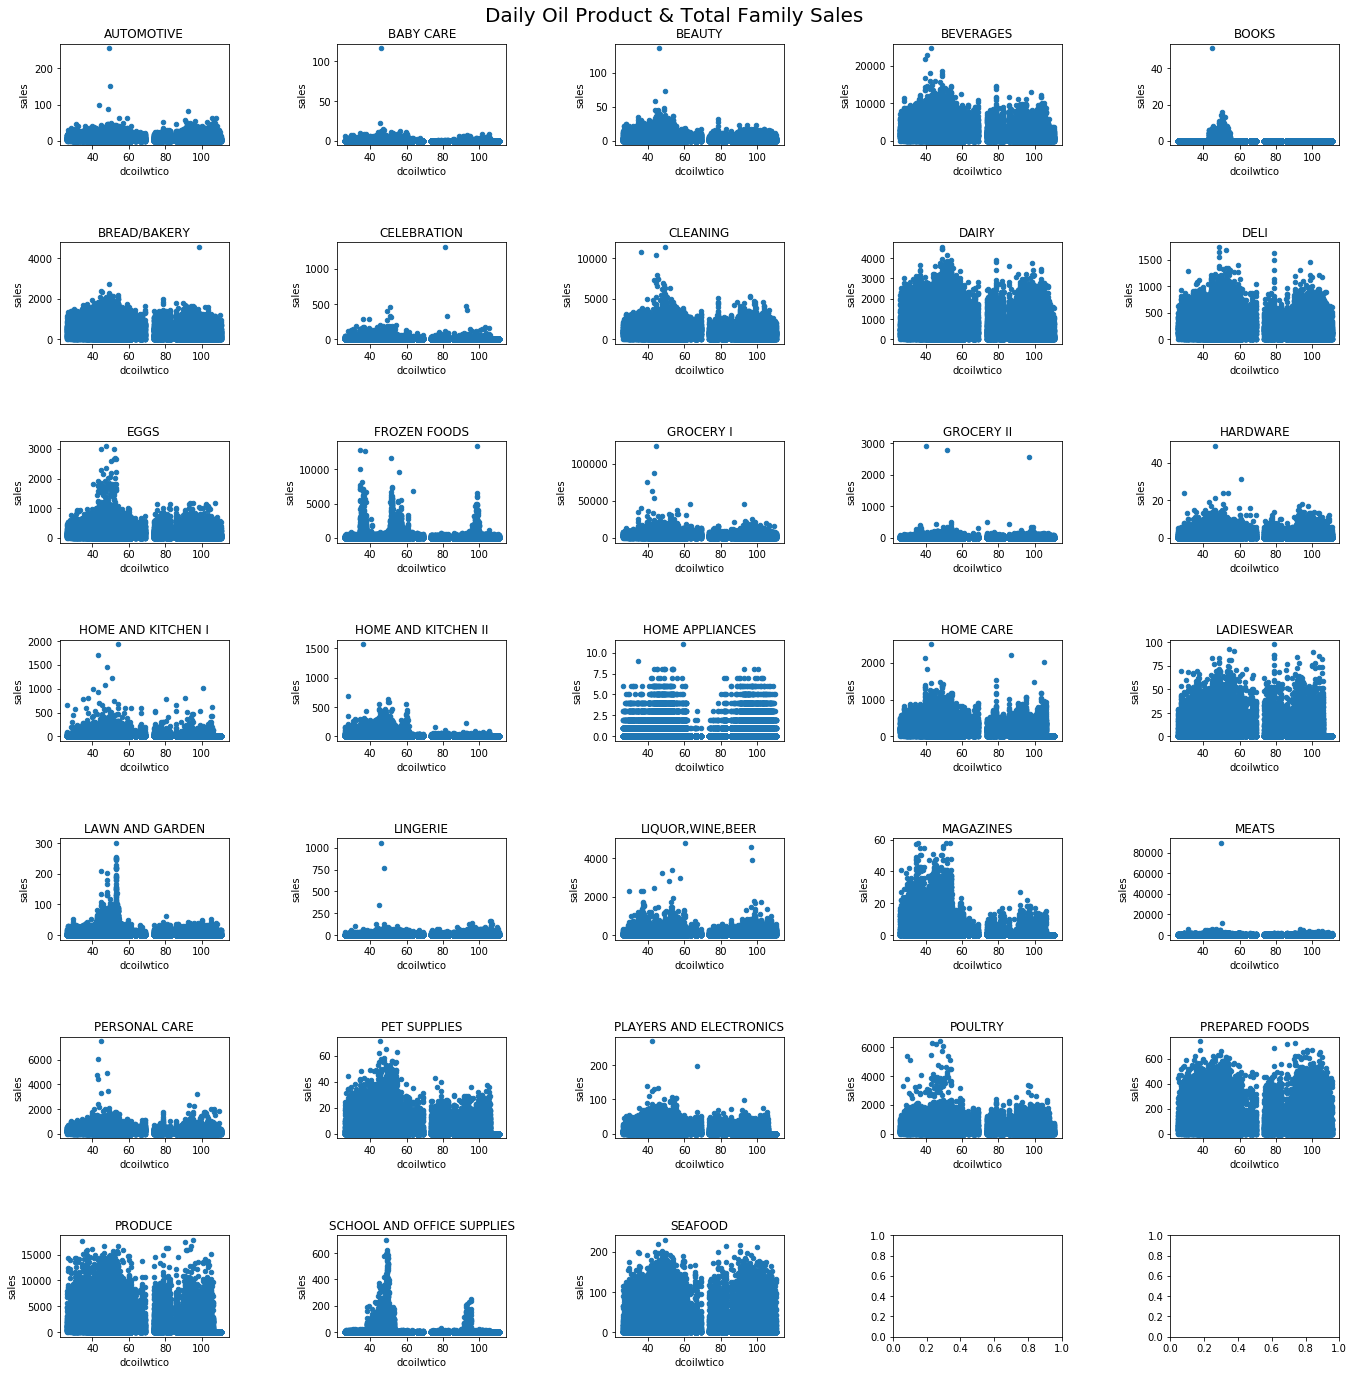

In [39]:
fig, axes = plt.subplots(7, 5, figsize = (20, 20))

for i, product in enumerate(np.unique(oil_sales.family)):
    temp = oil_sales[oil_sales.family == product]
    temp.plot.scatter(x = "dcoilwtico", y = "sales", ax=axes[int(i/5)][i%5])
    axes[int(i/5)][i%5].set_title(product)

plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize = 20)
plt.show()

In [ ]:
# conduct statistical test to see if promotion helps. NOTE: how to take into account correlation and check for independence?

# ideas: check for independence across stores: 
#        check for independence across days: 
#        check for independence across products:

Since sales have different units, it only makes sense to look at sales on product level, otherwise use number of transactions as a better metrics.
1. Transactions: It's always peak at the end of the end
    - Daily total number of transactions of different stores. 
    - Monthly average number of transactions of different stores.
    - Average number of transactions by day of week by year
    - Average number of transactions by day of month by year
2. Products: Grocery I is the all time highest and rising over years.
    - Daily sales of different products across all stores.
    - Monthly sales of different products aggregated across all stores.
    - Ranked total sales of all products
3. Store types: Store type A have more transactions
    - Average number of transactions by different store types and by year
4. Oil price: two clusters; there are three visible patterns: 1) sales are similar across all oil prices (seafood, produce, prepared foods, ladieswear, 
home appliances, beverages, diary, deli, bread/bakery, cleaning), this group is not impacted by oil prices 2) peak when oil price around 40 (poultry, 
lawn and garden, magazines, pet supplies, eggs, books) and 3) two peaks when price is ~ 40 and when price is around 100 (school supplies, liquor, frozen
foods) 
    - Daily oil price and daily total transaction
    - Daily Oil Price and daily total sales
    - Daily Oil Price and total sales by products
5. On promotion:
    - Overall, does promotion help increase monthly sales/transactions?
    - Is there a region where promotion greatly increase sales?
    - Is there a product that promotion impact sales positively